## Description

TODO

## Imports

In [26]:
import os
import ipdb
from typing import List, Dict
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)
from hipe_commons.helpers.tsv import HipeDocument, HipeEntity, parse_tsv, ENTITY_TYPES
#from hipe_commons.stats import count_entities
from hipe_commons.stats import compute_entities_stats

## TODOs

- in `hipe_commons.helpers.tsv.lines2entity` keep the flags contained in `line.misc` as this contains the LED flag
- in the count of NIL for `ajmc`, exclude entities that participants are not supposed to link

## Functions

In [2]:
# slightly modified version of the original function
def count_entities(docs: List[HipeDocument], exclude_from_NIL: List[str] = []) -> Dict:

    counts = {}
    
    for e_type in ENTITY_TYPES:
        for doc in docs:
            if e_type in doc.entities:
                if e_type not in counts:
                    counts[e_type] = 0
                counts[e_type] += len(doc.entities[e_type])
                
    # count the NIL entities
    # TODO: for ajmc, exclude from counts those that are not
    # supposed to be linked as per participation guidelines
                
    nil_entities_count = 0
    wikidata_linked_count = 0
    nonlinked_count = 0
    noisy_entities_count = 0
    for doc in docs:
        
        if not 'coarse_lit' in doc.entities:
            continue
        
        for entity in doc.entities['coarse_lit']:
            
            if entity.wikidata_id is not None:
                if entity.wikidata_id == "NIL":
                    
                    if entity.tag in exclude_from_NIL:
                        nonlinked_count += 1
                    else:
                        nil_entities_count += 1
                
                elif entity.wikidata_id != "NIL":
                    wikidata_linked_count += 1
            else:
                nonlinked_count += 1
                
            if entity.LED and entity.LED > 0:
                noisy_entities_count += 1
                
    counts['nil'] = nil_entities_count
    counts['wikidata_link'] = wikidata_linked_count
    counts['non_linked'] = nonlinked_count
    counts['noisy'] = noisy_entities_count
    return counts

In [3]:
def compute_dataset_stats(**kwargs):
    if "file_path" in kwargs:
        path = kwargs['file_path']
        docs = parse_tsv(file_path=path)
    elif "file_url" in kwargs:
        path = kwargs['file_url']
        docs = parse_tsv(file_url=path)
    elif "documents" in kwargs:
        docs = kwargs['documents']
        path = docs[0].path
    else:
        raise
        
    total_n_tokens = sum([
        doc.n_tokens
        for doc in docs
    ])
    
    entity_counts = count_entities(docs, exclude_from_NIL=['time'])
        
    data = {
        "n_docs": len(docs),
        "total_n_tokens": total_n_tokens,
        "n_mentions": entity_counts['coarse_lit'],
        "n_nested": entity_counts['nested'] if 'nested' in entity_counts else None,
        "n_nil": entity_counts['nil'],
        "n_wikidata_link": entity_counts['wikidata_link'],
        "n_linkable_mentions": entity_counts['coarse_lit'] - entity_counts['non_linked'],
        "n_non_linked": entity_counts['non_linked'],
        "n_noisy": entity_counts['noisy']
    }
    
    return pd.DataFrame([data])

In [4]:
def collect_entities(documents: List[HipeDocument]) -> Dict[str, List[HipeEntity]]:
    """Simple function to gather all entities from documents in a dataset, divided by type.

    :param documents: Input documents in HIPE format
    :type documents: List[HipeDocument]
    :return: A list of `HipeEntity` objects
    :rtype: Dict[str, List[HipeEntity]]
    """
    all_entities = {}

    for doc in documents:
        for e_type in ENTITY_TYPES:
            
            if e_type in doc.entities:

                if e_type not in all_entities:
                    all_entities[e_type] = []

                all_entities[e_type] += doc.entities[e_type]
    return all_entities

## Config

In [5]:
RELEASE_VERSION = "v2.1"
HIPE2022_data_path = f"./data/{RELEASE_VERSION}/"

In [6]:
hipe2022_corpus = {
    "ajmc": {
        "de": {
            "train": os.path.join(HIPE2022_data_path, f"ajmc/de/HIPE-2022-{RELEASE_VERSION}-ajmc-train-de.tsv"),
            "dev": os.path.join(HIPE2022_data_path, f"ajmc/de/HIPE-2022-{RELEASE_VERSION}-ajmc-dev-de.tsv"),
            "test": os.path.join(HIPE2022_data_path, f"ajmc/de/HIPE-2022-{RELEASE_VERSION}-ajmc-test-de.tsv")
        },
        "en": {
            "train": os.path.join(HIPE2022_data_path, f"ajmc/en/HIPE-2022-{RELEASE_VERSION}-ajmc-train-en.tsv"),
            "dev": os.path.join(HIPE2022_data_path, f"ajmc/en/HIPE-2022-{RELEASE_VERSION}-ajmc-dev-en.tsv"),
            "test": os.path.join(HIPE2022_data_path, f"ajmc/en/HIPE-2022-{RELEASE_VERSION}-ajmc-test-en.tsv")
        },
        "fr": {
            "train": os.path.join(HIPE2022_data_path, f"ajmc/fr/HIPE-2022-{RELEASE_VERSION}-ajmc-train-fr.tsv"),
            "dev": os.path.join(HIPE2022_data_path, f"ajmc/fr/HIPE-2022-{RELEASE_VERSION}-ajmc-dev-fr.tsv"),
            "test": os.path.join(HIPE2022_data_path, f"ajmc/fr/HIPE-2022-{RELEASE_VERSION}-ajmc-test-fr.tsv")
        }
    },
    "hipe2020": {
        "de": {
            "train": os.path.join(HIPE2022_data_path, f"hipe2020/de/HIPE-2022-{RELEASE_VERSION}-hipe2020-train-de.tsv"),
            "dev": os.path.join(HIPE2022_data_path, f"hipe2020/de/HIPE-2022-{RELEASE_VERSION}-hipe2020-dev-de.tsv"),
            "test": os.path.join(HIPE2022_data_path, f"hipe2020/de/HIPE-2022-{RELEASE_VERSION}-hipe2020-test-de.tsv")
        },
        "en": {
            "dev": os.path.join(HIPE2022_data_path, f"hipe2020/en/HIPE-2022-{RELEASE_VERSION}-hipe2020-dev-en.tsv"),
            "test": os.path.join(HIPE2022_data_path, f"hipe2020/en/HIPE-2022-{RELEASE_VERSION}-hipe2020-test-en.tsv")
        },
        "fr": {
            "train": os.path.join(HIPE2022_data_path, f"hipe2020/fr/HIPE-2022-{RELEASE_VERSION}-hipe2020-train-fr.tsv"),
            "dev": os.path.join(HIPE2022_data_path, f"hipe2020/fr/HIPE-2022-{RELEASE_VERSION}-hipe2020-dev-fr.tsv"),
            "test": os.path.join(HIPE2022_data_path, f"hipe2020/fr/HIPE-2022-{RELEASE_VERSION}-hipe2020-test-fr.tsv")
        }
    },
     "letemps": {
        "fr": {
            "train": os.path.join(HIPE2022_data_path, f"letemps/fr/HIPE-2022-{RELEASE_VERSION}-letemps-train-fr.tsv"),
            "dev": os.path.join(HIPE2022_data_path, f"letemps/fr/HIPE-2022-{RELEASE_VERSION}-letemps-dev-fr.tsv"),
            "test": os.path.join(HIPE2022_data_path, f"letemps/fr/HIPE-2022-{RELEASE_VERSION}-letemps-test-fr.tsv")
        }
    },
    "sonar": {
        "de": {
            "dev": os.path.join(HIPE2022_data_path, f"sonar/de/HIPE-2022-{RELEASE_VERSION}-sonar-dev-de.tsv"),
            "test": os.path.join(HIPE2022_data_path, f"sonar/de/HIPE-2022-{RELEASE_VERSION}-sonar-test-de.tsv")
        }
    },
    "newseye": {
        "fr" : {
            "train": os.path.join(HIPE2022_data_path, f"newseye/fr/HIPE-2022-{RELEASE_VERSION}-newseye-train-fr.tsv"),
            "dev": os.path.join(HIPE2022_data_path, f"newseye/fr/HIPE-2022-{RELEASE_VERSION}-newseye-dev-fr.tsv"),
            "test": os.path.join(HIPE2022_data_path, f"newseye/fr/HIPE-2022-{RELEASE_VERSION}-newseye-test-fr.tsv")
        },
        "de" : {
            "train": os.path.join(HIPE2022_data_path, f"newseye/de/HIPE-2022-{RELEASE_VERSION}-newseye-train-de.tsv"),
            "dev": os.path.join(HIPE2022_data_path, f"newseye/de/HIPE-2022-{RELEASE_VERSION}-newseye-dev-de.tsv"),
            "test": os.path.join(HIPE2022_data_path, f"newseye/de/HIPE-2022-{RELEASE_VERSION}-newseye-test-de.tsv")

        },
        "fi": {
            "train": os.path.join(HIPE2022_data_path, f"newseye/fi/HIPE-2022-{RELEASE_VERSION}-newseye-train-fi.tsv"),
            "dev": os.path.join(HIPE2022_data_path, f"newseye/fi/HIPE-2022-{RELEASE_VERSION}-newseye-dev-fi.tsv"),
            "test": os.path.join(HIPE2022_data_path, f"newseye/fi/HIPE-2022-{RELEASE_VERSION}-newseye-test-fi.tsv")
        },
        "sv": {
            "train": os.path.join(HIPE2022_data_path, f"newseye/sv/HIPE-2022-{RELEASE_VERSION}-newseye-train-sv.tsv"),
            "dev": os.path.join(HIPE2022_data_path, f"newseye/sv/HIPE-2022-{RELEASE_VERSION}-newseye-dev-sv.tsv"),
            "test": os.path.join(HIPE2022_data_path, f"newseye/sv/HIPE-2022-{RELEASE_VERSION}-newseye-test-sv.tsv")
        },
    },
    "topres19th": {
        "en": {
            "train": os.path.join(HIPE2022_data_path, f"topres19th/en/HIPE-2022-{RELEASE_VERSION}-topres19th-train-en.tsv"),
            "dev": os.path.join(HIPE2022_data_path, f"topres19th/en/HIPE-2022-{RELEASE_VERSION}-topres19th-dev-en.tsv"),
            "test": os.path.join(HIPE2022_data_path, f"topres19th/en/HIPE-2022-{RELEASE_VERSION}-topres19th-test-en.tsv")
        }
    },
    
}

## Table: corpus overview stats

In [27]:
datataset_overview_dfs = []

for dataset in hipe2022_corpus:
    
    for lang in hipe2022_corpus[dataset]:
        
        for split in hipe2022_corpus[dataset][lang]:
            
            dataset_path  = hipe2022_corpus[dataset][lang][split]
            try:
                datataset_df = compute_dataset_stats(file_path=dataset_path)
            except Exception as e:
                print(e)
                continue
            datataset_df['dataset'] = dataset
            datataset_df['language'] = lang
            datataset_df['split'] = split
            
            datataset_overview_dfs.append(datataset_df)
            
corpus_overview_df = pd.concat(datataset_overview_dfs)

In [30]:
column_filter = [
    "n_docs", "total_n_tokens", "n_mentions", "n_nested", "n_non_linked", "n_linkable_mentions", "n_nil", "n_noisy"
] 
corpus_overview_df.set_index(['dataset', 'language', 'split'])[column_filter]

n_docs  total_n_tokens  n_mentions n_nested  \
dataset    language split                                                
ajmc       de       train      76           22695        1738       11   
                    dev        14            4702         403        2   
                    test       16            4845         382     None   
           en       train      60           30932        1823        4   
                    dev        14            6506         416     None   
                    test       13            6052         348     None   
           fr       train      72           24669        1621        9   
                    dev        17            5425         391     None   
                    test       15            5390         360     None   
hipe2020   de       train     103           86445        3494      158   
                    dev        33           32671        1242       67   
                    test       49           30737        1147       73   
           en       dev        80           29063         966     None   
                    test       46           16634         449     None   
           fr       train     158          166220        6926      473   
                    dev        43           37953        1729       91   
                    test       43           40854        1600       82   
letemps    fr       train     414          379487        9159       69   
                    dev        51           38649         869       12   
                    test       51           48468        1017       12   
sonar      de       dev        10           17476         654     None   
                    test       10           15463         471     None   
newseye    fr       train      35          255165       10423      522   
                    dev        35           21727         752       32   
                    test       35           70794        2530      136   
           de       train       7          374332       11381     1133   
                    dev        12           40061         539       29   
                    test       13           99775        2401      100   
           fi       train      24           48222        2146      225   
                    dev        24            6350         223       26   
                    test       24           14963         691       42   
           sv       train      21           56306        2141      126   
                    dev        21            6906         266        9   
                    test       21           16162         604       26   
topres19th en       train     309          123983        3182     None   
                    dev        34           11917         237     None   
                    test      112           43270        1187     None   

                           n_non_linked  n_linkable_mentions  n_nil  n_noisy  
dataset    language split                                                     
ajmc       de       train           883                  855     16      240  
                    dev             182                  221      3       46  
                    test            192                  190      7       42  
           en       train           773                 1050     30      200  
                    dev             186                  230      7       70  
                    test            165                  183      9       36  
           fr       train           711                  910     16      498  
                    dev             177                  214     10      142  
                    test            143                  217     10       99  
hipe2020   de       train           118                 3376    526        0  
                    dev              69                 1173    219        0  
                    test             49                 1098    191        0  
           en       dev           

In [31]:
corpus_overview_df.set_index(['dataset', 'language', 'split'])[['n_linkable_mentions']]

n_linkable_mentions
dataset    language split                     
ajmc       de       train                  855
                    dev                    221
                    test                   190
           en       train                 1050
                    dev                    230
                    test                   183
           fr       train                  910
                    dev                    214
                    test                   217
hipe2020   de       train                 3376
                    dev                   1173
                    test                  1098
           en       dev                    937
                    test                   432
           fr       train                 6650
                    dev                   1661
                    test                  1547
letemps    fr       train                    0
                    dev                      0
                    test                     0
sonar      de       dev                    654
                    test                   471
newseye    fr       train                10423
                    dev                    752
                    test                  2530
           de       train                11381
                    dev                    539
                    test                  2401
           fi       train                 2146
                    dev                    223
                    test                   691
           sv       train                 2141
                    dev                    266
                    test                   604
topres19th en       train                 3182
                    dev                    237
                    test                  1187

In [16]:
corpus_overview_df.set_index(['dataset', 'language', 'split'])[["n_nil"]]

n_nil
dataset    language split       
ajmc       de       train     16
                    dev        3
                    test       7
           en       train     30
                    dev        7
                    test       9
           fr       train     16
                    dev       10
                    test      10
hipe2020   de       train    526
                    dev      219
                    test     191
           en       dev      414
                    test     174
           fr       train   1674
                    dev      329
                    test     312
letemps    fr       train      0
                    dev        0
                    test       0
sonar      de       dev      147
                    test     157
newseye    fr       train   4421
                    dev      229
                    test    1134
           de       train   5812
                    dev      119
                    test    1165
           fi       train    865
                    dev       90
                    test     328
           sv       train    694
                    dev       67
                    test     214
topres19th en       train    585
                    dev       34
                    test     205

In [114]:
corpus_overview_df.set_index(['dataset', 'language', 'split'])[["n_noisy"]]

n_noisy
dataset language split         
ajmc    de       train      240
                 dev         46
                 test        42
        en       train      200
                 dev         70
                 test        36
        fr       train      498
                 dev        142
                 test        99

## Table: entity types

Produce entity counts for all dataset for coarse/fine types, to derive the list of entity types found.

In [56]:
coarse_entities_dfs = []
fine_entities_dfs = []

for dataset in hipe2022_corpus:
    
    tmp_entity_stats = []
    dataset_docs = []
    
    for lang in hipe2022_corpus[dataset]:
        
        for split in hipe2022_corpus[dataset][lang]:
            
            docs = parse_tsv(
                file_path=hipe2022_corpus[dataset][lang][split]
            )
            
            dataset_docs.append(
                (docs, lang)
            )
    
    for docs, lang in dataset_docs:
        print(dataset, len(docs))
        entity_stats = compute_entities_stats(docs, lang)
        tmp_entity_stats.append(entity_stats)
        
        
    coarse_entities_stats = pd.concat(
        [
            df['coarse_lit'].reset_index().rename(
                columns={'index': 'coarse_type'}
            )
            for df in tmp_entity_stats
        ]
    )
    coarse_entities_stats['dataset'] = dataset
    coarse_entities_dfs.append(coarse_entities_stats)

    """
    # process counts of fine entities
    if 'fine_lit' in entity_stats:
        fine_entities_stats = entity_stats['fine_lit'].reset_index().rename(columns={'index': 'fine_type'})
        fine_entities_stats['dataset'] = dataset
        fine_entities_dfs.append(fine_entities_stats)
    """

ajmc 76
ajmc 14
ajmc 16
ajmc 60
ajmc 14
ajmc 13
ajmc 72
ajmc 17
ajmc 15
hipe2020 103
hipe2020 33
hipe2020 49
hipe2020 80
hipe2020 46
hipe2020 158
hipe2020 43
hipe2020 43
letemps 414
letemps 51
letemps 51
sonar 10
sonar 10
newseye 35
newseye 35
newseye 35
newseye 7
newseye 12
newseye 13
newseye 24
newseye 24
newseye 24
newseye 21
newseye 21
newseye 21
topres19th 309
topres19th 34
topres19th 112


In [61]:
#coarse_entities_df = pd.concat(coarse_entities_dfs).set_index(['dataset', 'coarse_type'])
coarse_entities_df = pd.concat(coarse_entities_dfs)

In [62]:
coarse_entities_df[coarse_entities_df.dataset=='sonar']

,coarse_type,count,language,dataset
0,LOC,300,de,sonar
1,ORG,138,de,sonar
2,PER,216,de,sonar
0,LOC,177,de,sonar
1,ORG,111,de,sonar
2,PER,183,de,sonar


In [63]:
coarse_entities_df.groupby(['coarse_type','dataset','language']).sum()

count
coarse_type dataset    language       
BUILDING    topres19th en          563
HumanProd   newseye    de           56
                       fi          160
                       fr          244
                       sv          203
LOC         newseye    de         6620
                       fi         1338
                       fr         5502
                       sv         1446
            sonar      de          477
            topres19th en         3727
ORG         newseye    de         3584
                       fi          350
                       fr         1758
                       sv          230
            sonar      de          249
PER         newseye    de         4061
                       fi         1212
                       fr         6201
                       sv         1132
            sonar      de          399
STREET      topres19th en          316
date        ajmc       de            2
                       en           20
                       fr            5
loc         ajmc       de           43
                       en           45
                       fr           24
            hipe2020   de         2923
                       en          565
                       fr         4717
            letemps    fr         6367
object      ajmc       de           12
                       en            3
                       fr           10
org         hipe2020   de          652
                       en          194
                       fr         1125
            letemps    fr          592
pers        ajmc       de          910
                       en          844
                       fr          839
            hipe2020   de         1849
                       en          558
                       fr         3706
            letemps    fr         4086
prod        hipe2020   de          223
                       en           52
                       fr          310
scope       ajmc       de         1091
                       en          997
                       fr          937
time        hipe2020   de          236
                       en           46
                       fr          397
work        ajmc       de          465
                       en          678
                       fr          557

In [37]:
fine_entities_df = pd.concat(fine_entities_dfs).set_index(['dataset', 'fine_type'])

In [41]:
fine_entities_df

count
dataset  fine_type                    
ajmc     date                       27
         loc                       112
         object.manuscr             25
         pers.author              1244
         pers.editor               173
         pers.myth                 939
         pers.other                237
         scope                    3025
         work.fragm                 12
         work.journal                1
         work.other                  3
         work.primlit             1601
         work.seclit                83
hipe2020 loc.add.elec                1
         loc.add.phys                6
         loc.adm.nat              1915
         loc.adm.reg               932
         loc.adm.sup               180
         loc.adm.town             3769
         loc.fac                   163
         loc.oro                   201
         loc.phys.astro             12
         loc.phys.geo              212
         loc.phys.hydro            238
         loc.unk                    11
         org.adm                   523
         org.ent                  1098
         org.ent.pressagency       156
         pers.coll                  50
         pers.ind                 5381
         pers.ind.articleauthor    124
         prod.doctr                 80
         prod.media                453
         time.date.abs             633
letemps  loc                       294
         loc.add                     5
         loc.add.phys              198
         loc.adm                   141
         loc.adm.nat              1356
         loc.adm.reg               567
         loc.adm.town             3294
         loc.admin.sup              37
         loc.oro                    13
         loc.phys                   16
         loc.phys.astro             10
         loc.phys.geo              319
         loc.phys.hydro            117
         org.adm                   219
         org.ent                   373
         pers                       61
         pers.coll                 164
         pers.ind                 3861
newseye  PER.author                215

## Distribution of LED in noisy entities (ajmc)

In [37]:
def extract_entity_info(doc: HipeDocument, entity_type: str):
    entities = []
    for mention in doc.entities[entity_type]:
        entities.append(
            {
            'surface': mention.text,
            'LED': mention.LED,
            'wikidata_id': mention.wikidata_id
            }
        )
    return entities

In [54]:
intermediate_dfs = []

for dataset in hipe2022_corpus:
    
    if dataset != 'ajmc':
        continue

    for lang in hipe2022_corpus[dataset]:
        
        for split in hipe2022_corpus[dataset][lang]:
            
            dataset_path  = hipe2022_corpus[dataset][lang][split]
            docs = parse_tsv(file_path=dataset_path)
            
            try:
                entities_info = []
                for doc in docs:
                    entities_info += extract_entity_info(doc, entity_type='coarse_lit')
                dataset_df = pd.DataFrame(entities_info)
            except Exception as e:
                print(e)
                continue
            dataset_df['dataset'] = dataset
            dataset_df['language'] = lang
            dataset_df['split'] = split
            
            intermediate_dfs.append(dataset_df)
            
entities_df = pd.concat(intermediate_dfs)

'coarse_lit'


In [94]:
entities_df

,surface,LED,wikidata_id,dataset,split
language,,,,,
de,Sophokles,0.0,Q11950683,ajmc,train
de,Sophokles,0.0,Q11950683,ajmc,train
de,Sophokles,0.0,Q11950683,ajmc,train
de,Cobet,0.0,Q743457,ajmc,train
de,Laur. A,0.0,None,ajmc,train
...,...,...,...,...,...
fr,Botbe,0.2,NIL,ajmc,test
fr,Reisig,0.0,Q90245,ajmc,test
fr,Eschyle,0.0,Q40939,ajmc,test


In [115]:
# keep only the entities that are affected by OCR noise
noisy_entities_df = entities_df[entities_df['LED']> 0]

In [101]:
grouped = noisy_entities_df[['LED']].groupby('language')

de         AxesSubplot(0.1,0.15;0.235294x0.75)
en    AxesSubplot(0.382353,0.15;0.235294x0.75)
fr    AxesSubplot(0.664706,0.15;0.235294x0.75)
dtype: object

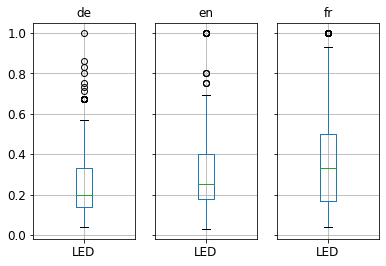

In [116]:
# the plot shows the distribution of LED values of noisy entities in the ajmc data
grouped.boxplot(fontsize=12, layout=(1, 3))

In [117]:
# and here the underlying numbers
noisy_entities_df[['LED']].groupby('language').describe()

LED                                                 
          count      mean       std   min   25%   50%   75%  max
language                                                        
de        328.0  0.254451  0.167718  0.04  0.14  0.20  0.33  1.0
en        270.0  0.320556  0.208155  0.03  0.18  0.25  0.40  1.0
fr        739.0  0.398092  0.275792  0.04  0.17  0.33  0.50  1.0

## Memory baseline

define a function that
- works per dataset / language
- works by comparing two sets of splits (train vs test, train+dev vs test)
- takes all mentions, and returns the number/percentage of overlapping mentions (exact same surface form)
- takes all linked entities, and returns the number/percentage of overlapping entities

needs:
- index: language, dataset, 
- number of mentions
- number of unique mentions
- number of overlapping mentions
- number of linked entities
- number of unique linked entities
- number of overlapping entities

tables:
- one table for train vs test comparison
- one table for train+dev vs test
(or combine the two tables together)

NB:
- remove trailing spaces
- lowercase everything (?)

In [41]:
def compute_overlapping_mentions(mentions_list_1, mentions_list_2):
    print(f"List 1 contains {len(mentions_list_1)} mentions")
    print(f"List 2 contains {len(mentions_list_2)} mentions")
    
    norm_list_1 = [
        mention.lower().strip()
        for mention in mentions_list_1
    ]
    
    norm_list_2 = [
        mention.lower().strip()
        for mention in mentions_list_2
    ]
    
    #print(norm_list_1[:5])
    #print(norm_list_2[:5])
   
    overlapping_mentions_sets = set(norm_list_1).intersection(set(norm_list_2))
    overlapping_mentions_lists = [item for item in norm_list_1 if item in norm_list_2]
    print(sorted(overlapping_mentions_lists))
    
    n_total_mentions = len(norm_list_1) + len(norm_list_2)
    n_unique_mentions = len(set(norm_list_1 + norm_list_2))
    n_overlapping_mentions_sets = len(overlapping_mentions_sets)
    n_overlapping_mentions_lists = len(overlapping_mentions_lists)

    return {
        "n_mentions": n_total_mentions,
        "n_unique_mentions": n_unique_mentions,
        "n_overlapping_mentions_sets": n_overlapping_mentions_sets,
        "n_overlapping_mentions_lists": n_overlapping_mentions_lists,
        "pct_overlapping_mentions_sets": (n_overlapping_mentions_sets / n_unique_mentions),
        "pct_overlapping_mentions_lists": (n_overlapping_mentions_lists / n_unique_mentions),
        #"pct_unique_mentions_sets": (n_unique_mentions / n_total_mentions)*10,
    }

In [42]:
def compute_overlapping_entities(entities_list_1, entities_list_2):
    pass

In [43]:
overlap_data = []

for dataset in hipe2022_corpus:
    
    #if dataset != 'hipe2020' and dataset != 'ajmc':
    #    continue

    for lang in hipe2022_corpus[dataset]:
        
        curr_corpus = hipe2022_corpus[dataset][lang]
        
        dataset_dev_path = curr_corpus['dev']
        dataset_train_path = curr_corpus['train'] if 'train' in curr_corpus else None
        dataset_test_path = curr_corpus['test']
        
        dev_docs = parse_tsv(file_path=dataset_dev_path)
        train_docs = parse_tsv(file_path=dataset_train_path) if dataset_train_path else None
        test_docs = parse_tsv(file_path=dataset_test_path)
        
        dev_entities = collect_entities(dev_docs)['coarse_lit']
        train_entities = collect_entities(train_docs)['coarse_lit'] if train_docs else []
        test_entities = collect_entities(test_docs)['coarse_lit']
        
        
        print(dataset, lang, 'train', len(train_entities))
        print(dataset, lang, 'dev', len(dev_entities))
        print(dataset, lang, 'test', len(test_entities))
        
        if 'train' in curr_corpus:
        
            tmp_data = compute_overlapping_mentions(
                [entity.text for entity in train_entities],
                [entity.text for entity in test_entities],
            )
            tmp_data['dataset'] = dataset
            tmp_data['language'] = lang
            tmp_data['setting'] = "train vs test"

            overlap_data.append(tmp_data)
        
        tmp_data = compute_overlapping_mentions(
            [entity.text for entity in train_entities + dev_entities],
            [entity.text for entity in test_entities],
        )
        tmp_data['dataset'] = dataset
        tmp_data['language'] = lang
        tmp_data['setting'] = "train+dev vs test" if "train" in curr_corpus else "dev vs test"

        overlap_data.append(tmp_data)
        
        #ipdb.set_trace()

ajmc de train 1738
ajmc de dev 403
ajmc de test 382
List 1 contains 1738 mentions
List 2 contains 382 mentions
['0. c.', '0. c.', '0. c.', '0. c.', '0. c.', '0. c.', '0. c.', '0. c.', '0. r.', '0. r.', '0. r.', '0. r.', '0. r.', '0. r.', '0. r.', '0. r.', '0. r.', '0. r.', '0. r.', '0. r.', '0. r.', '1.', '1.', '1.', '1.', '106', '1135', '1197', '12', '12', '1316', '1316', '146', '191', '206', '229', '23', '254', '257', '257', '257', '267', '269', '272', '303', '303', '309', '320', '36', '377', '443', '468', '496', '517', '52', '531', '546', '59', '658', '69', '719', '78', '840', '924', '98', '98', '998', 'a.', 'a.', 'achilleus', 'achilleus', 'achilleus', 'achilleus', 'achilleus', 'achilleus', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'ag.', 'ag.', 'ag.', 'ag.', 'ag.', 'ag.', 'ag.', 'ag.', 'ag.', 'aias', 'aias', 'aias', 'aias', 'aias', 'aias', 'aias', 'aias', 'aias', 'aias', 'aias', 'aias'

ajmc en train 1823
ajmc en dev 416
ajmc en test 348
List 1 contains 1823 mentions
List 2 contains 348 mentions
['1061', '108', '145', '193', '31', '32', '32', '366', '366', '379', '379', '408', '44', '519', '54', '6. 37', '628', '7', '929', '94', 'achilles', 'achilles', 'achilles', 'achilles', 'achilles', 'achilles', 'achilles', 'achilles', 'achilles', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'aesch.', 'ag.', 'ag.', 'ag.', 'ag.', 'ag.', 'ag.', 'ag.', 'ag.', 'ag.', 'agamemnon', 'agamemnon', 'agamemnon', 'agamemnon', 'agamemnon', 'agamemnon', 'agamemnon', 'agamemnon', 'agamemnon', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'aj

ajmc fr train 1621
ajmc fr dev 391
ajmc fr test 360
List 1 contains 1621 mentions
List 2 contains 360 mentions
['164', '20', '239', '404', '404', '435', '438', '438', '472', '495', '498', '725', '8', '861', '861', '978', 'agamemnon', 'agamemnon', 'agamemnon', 'agamemnon', 'agamemnon', 'agamemnon', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'ajax', 'alceste', 'alceste', 'alceste', 'androm.', 'antig.', 'antig.', 'antig.', 'antig.', 'antig.', 'antig.', 'antig.', 'antig.', 'antig.', 'antig.', 'antig.', 'antig.', 'antig.', 'antig.', 'antig.', 'antig.', 'antig.', 'antigone', 'antigone', 'antigone', 'antigone', 'antigone', 'antigone', 'antigone', 'aristophane', 'aristophane', 'aristophane', 'athènes', 'athènes', 'brunck', 'brunck', 'brunck', 'brunck', 'brunck', 'brunck', 'chevaliers', 'dindo

hipe2020 de train 3494
hipe2020 de dev 1242
hipe2020 de test 1147
List 1 contains 3494 mentions
List 2 contains 1147 mentions
['1873', '1878', 'aargau', 'aargau', 'alpen', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'ap', 'ap', 'appenzell', 'athen', 'athen', 'augsburg', 'bayern', 'bayern', 'belgien', 'belgien', 'belgien', 'belgien', 'belgien', 'belgien', 'belgien', 'belgien', 'belgien', 'belgien', 'belgien', 'belgien', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'bern', 'bern', 'bern', 'bern', 'bern', 'bern', 'bezirk schwyz', 'bosnien', 'bosnien', 'brüssel', 'brüssel', 'brüssel', 'brüssel', 'brüssel', 'brüssel', 'brüssel', 'budapest', 'bukarest', 'bund', 'bund', 'bund', 'bund', 'bundes', 'bundes', 'bundesrat', 'bundesrat', 'bundesrat', 'bundesrat', 'bundesrat', 'bundesrat', 'bundesrates', "buonap

hipe2020 en train 0
hipe2020 en dev 966
hipe2020 en test 449
List 1 contains 966 mentions
List 2 contains 449 mentions
['alexandria', 'alexandria', 'america', 'america', 'america', 'america', 'america', 'america', 'baltimore', 'baltimore', 'baltimore', 'baltimore', 'baltimore', 'baltimore', 'chicago', 'chicago', 'cookeville', 'cookeville', 'cookeville', 'cookeville', 'cookeville', 'cookeville', 'cookeville', 'cooke¬ ville', 'd. a. rawley', 'd. a. rawley', 'england', 'england', 'england', 'europe', 'ferdinand', 'france', 'france', 'france', 'france', 'france', 'france', 'gainesboro', 'gainesboro', 'idaho', 'james madison', 'london', 'loris', 'mansfield judd', 'maryland', 'moscow', 'new york', 'new york', 'new york', 'new york', 'new york', 'new york', 'new york', 'new-york', 'north carolina', 'north carolina', 'paris', 'paris', 'paris', 'paris', 'pennsylvania', 'philadelphia', 'philadelphia', 'philadelphia', 'philadelphia', 'philadelphia', 'pullman', 'pullman', 'senate', 'spain', 'st. l

['académie française', 'académie française', 'afp', 'afp', 'afp', 'afp', 'afp', 'afrique', 'afrique', 'aigle', 'aigle', 'aigle', 'aigle', 'aigle', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'amérique', 'amérique', 'amérique', 'amérique', 'amérique', 'amérique', 'amérique', 'amérique', 'amérique', 'amérique', 'amérique', 'amérique', 'angleterre', 'angleterre', 'angleterre', 'angleterre', 'an

letemps fr train 9159
letemps fr dev 869
letemps fr test 1017
List 1 contains 9159 mentions
List 2 contains 1017 mentions
['aarau', 'aarau', 'aarau', 'afp', 'afp', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'alexandre', 'alexandre', 'alexandrie', 'alexandrie', 'alexandrie', 'alexandrie', 'alexandrie', 'alexandrie', 'alexandrie', 'algérie', 'algérie', 'algérie', 'algérie', 'algérie', 'algérie', 'algérie', 'algérie', 'algérie', 'algérie', 'algérie', 'algérie', 'algérie', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne'

['aarau', 'aarau', 'aarau', 'afp', 'afp', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'afrique', 'alexandre', 'alexandre', 'alexandre', 'alexandre', 'alexandrie', 'alexandrie', 'alexandrie', 'alexandrie', 'alexandrie', 'alexandrie', 'alexandrie', 'alexandrie', 'algérie', 'algérie', 'algérie', 'algérie', 'algérie', 'algérie', 'algérie', 'algérie', 'algérie', 'algérie', 'algérie', 'algérie', 'algérie', 'algérie', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemag

sonar de train 0
sonar de dev 654
sonar de test 471
List 1 contains 654 mentions
List 2 contains 471 mentions
['berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berlin', 'berliner börſen⸗ zeitung', 'berliner börſen⸗ zeitung', 'bielefeld', 'bismarck', 'danzig', 'deutſchen reiches', 'deutſchland', 'deutſchland', 'deutſchland', 'deutſchland', 'deutſchland', 'deutſchland', 'frankfurt a . m .', 'frankfurt a . m .', 'frankfurt a . m .', 'frankreich', 'gpu', 'gpu', 'h . klee', 'hagen', 'hamburg', 'kaſſel', 'moskau', 'moskau', 'oeſ

['a.', 'a.', 'afrique', 'afrique', 'ajaccio', 'ajaccio', 'ajaccio', 'ajaccio', 'albi', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'allemagne', 'alle¬', 'alliés', 'alliés', 'alliés', 'alliés', 'alliés', 'alliés', 'alsace', 'alsace', 'alsace', 'alsace', 'alsace', 'alsace', 'al¬', 'al¬lemagne', 'al¬lemagne', 'ambigu', 'ambigu', '

newseye de train 11381
newseye de dev 539
newseye de test 2401
List 1 contains 11381 mentions
List 2 contains 2401 mentions
['a. siegle', 'abbazia', 'abbazia', 'abbazia', 'abbazia', 'abbazia', 'abbazia', 'abbazia', 'abbazia', 'abbazia', 'abbazia', 'abgeordnetenhaus', 'abgeordnetenhaus', 'abgeordnetenhaus', 'abgeordnetenhaus', 'abgeordnetenhaus', 'abgeordnetenhaus', 'abgeordnetenhaus', 'adolph werthner', 'afrika', 'agram', 'agram', 'agram', 'agram', 'agram', 'agram', 'agram', 'agram', 'agram', 'alexandria', 'alexandria', 'alfred v. berger', 'alfred v. berger', 'alfred v. berger', 'allgemeine baugesellschaft', 'allgemeine baugesellschaft', 'alvernia', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', '

['a. siegle', 'abbazia', 'abbazia', 'abbazia', 'abbazia', 'abbazia', 'abbazia', 'abbazia', 'abbazia', 'abbazia', 'abbazia', 'abgeordnetenhaus', 'abgeordnetenhaus', 'abgeordnetenhaus', 'abgeordnetenhaus', 'abgeordnetenhaus', 'abgeordnetenhaus', 'abgeordnetenhaus', 'abgeordnetenhaus', 'adolph werthner', 'afrika', 'agram', 'agram', 'agram', 'agram', 'agram', 'agram', 'agram', 'agram', 'agram', 'alexandria', 'alexandria', 'alfred v. berger', 'alfred v. berger', 'alfred v. berger', 'alfred v. berger', 'allgemeine baugesellschaft', 'allgemeine baugesellschaft', 'alvernia', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amerika', 'amsterd.', 'amsterdam', 'amsterdam', 'am

newseye fi train 2146
newseye fi dev 223
newseye fi test 691
List 1 contains 2146 mentions
List 2 contains 691 mentions
['aamul.', 'berliniin', 'englannin', 'englannin', 'englannin', 'englannin', 'englannin', 'englannin', 'englannin', 'englannin', 'englannin', 'englannin', 'englannin', 'englannin', 'englannissa', 'englannissa', 'englannissa', 'englanti', 'helsingissä', 'helsinkiin', 'helsinkiin', 'hra l.', 'itaalian', 'jumala', 'jumala', 'jumalan', 'jumalan', 'jumalan', 'jumalan', 'kapteeni ruth', 'kapteeni ruthin', 'kapteeni ruthin', 'kapteeni ruthin', 'kapteeniruth', 'keisari wilhelm', 'keisari wilhelm', 'keisari wilhelm', 'keisari wilhelm', 'lontoon', 'lontoon', 'lontoon', 'lontoon poliisi', 'lontoossa', 'lontoossa', 'lontoosta', 'lontoosta', 'lontoosta', 'newyorkista', 'oulun', 'oulun läänin', 'oulun läänin', 'oulun läänin', 'parisiin', 'parisista', 'pietariin', 'pietariin', 'pietariin', 'pietarissa', 'pietarissa', 'pietarissa', 'puccinin', 'rans-kan', 'rans-kan', 'ranskan', 'ransk

topres19th en train 3182
topres19th en dev 237
topres19th en test 1187
List 1 contains 3182 mentions
List 2 contains 1187 mentions
['africa', 'africa', 'africa', 'africa', 'america', 'america', 'america', 'america', 'america', 'america', 'america', 'america', 'america', 'america', 'america', 'america', 'angel', 'anns square', 'archipelago', 'archipelago', 'ashton', 'ashton', 'ashton', 'ashton', 'ashton', 'ashton', 'ashton', 'ashton', 'ashton', 'ashton', 'ashton-under-lyne', 'ashton-under-lyne', 'ashton-under-lyne', 'ashton-under-lyne', 'ashton-under-lyne', 'ashton-under-lyne', 'ashton-under-lyne', 'ashton-under-lyne', 'assembly rooms', 'athens', 'australia', 'australia', 'australia', 'australia', 'australia', 'austria', 'austria', 'ave maria lane', 'bahamas', 'basingstoke', 'bath', 'bath', 'bath', 'bath', 'bath', 'bath', 'bath', 'bath', 'bath', 'bath', 'bath', 'bavaria', 'bavaria', 'belgium', 'belgium', 'belgium', 'belgium', 'belgium', 'belgium', 'bengal', 'bengal', 'bengal', 'berlin',

In [38]:
df = pd.DataFrame(overlap_data).set_index(['dataset', 'language'])

In [39]:
df

n_mentions  n_unique_mentions  \
dataset    language                                  
ajmc       de              2120               1139   
           de              2523               1305   
           en              2171               1174   
           en              2587               1380   
           fr              1981               1230   
           fr              2372               1432   
hipe2020   de              4641               2935   
           de              5883               3695   
           en              1415               1112   
           fr              8526               5007   
           fr             10255               5939   
letemps    fr             10176               5198   
           fr             11045               5601   
sonar      de              1125                780   
newseye    fr             12953               8577   
           fr             13705               8970   
           de             13782               8341   
           de             14321               8577   
           fi              2837               2303   
           fi              3060               2468   
           sv              2745               2069   
           sv              3011               2226   
topres19th en              4369               2130   
           en              4606               2213   

                     n_overlapping_mentions_sets  \
dataset    language                                
ajmc       de                                 90   
           de                                103   
           en                                 73   
           en                                 79   
           fr                                 75   
           fr                                 81   
hipe2020   de                                114   
           de                                128   
           en                                 36   
           fr                                195   
           fr                                223   
letemps    fr                                178   
           fr                                184   
sonar      de                                 28   
newseye    fr                                300   
           fr                                317   
           de                                294   
           de                                301   
           fi                                 56   
           fi                                 59   
           sv                                 61   
           sv                                 69   
topres19th en                                224   
           en                                233   

                     n_overlapping_mentions_lists  \
dataset    language                                 
ajmc       de                                 642   
           de                                 793   
           en                                 652   
           en                                 789   
           fr                                 532   
           fr                                 653   
hipe2020   de                                 703   
           de                                 954   
           en                                  88   
           fr                                1522   
           fr                                1963   
letemps    fr                                2589   
           fr                                2839   
sonar      de                                 114   
newseye    fr                                1823   
           fr                                2027   
           de                                2787   
           de                                2974   
           fi                                 180   
           fi                                 203   
           sv                                 260   
           sv                               

In [40]:
df[(df['setting']=='train+dev vs test') | (df['setting']=='dev vs test')]

n_mentions  n_unique_mentions  \
dataset    language                                  
ajmc       de              2523               1305   
           en              2587               1380   
           fr              2372               1432   
hipe2020   de              5883               3695   
           en              1415               1112   
           fr             10255               5939   
letemps    fr             11045               5601   
sonar      de              1125                780   
newseye    fr             13705               8970   
           de             14321               8577   
           fi              3060               2468   
           sv              3011               2226   
topres19th en              4606               2213   

                     n_overlapping_mentions_sets  \
dataset    language                                
ajmc       de                                103   
           en                                 79   
           fr                                 81   
hipe2020   de                                128   
           en                                 36   
           fr                                223   
letemps    fr                                184   
sonar      de                                 28   
newseye    fr                                317   
           de                                301   
           fi                                 59   
           sv                                 69   
topres19th en                                233   

                     n_overlapping_mentions_lists  \
dataset    language                                 
ajmc       de                                 793   
           en                                 789   
           fr                                 653   
hipe2020   de                                 954   
           en                                  88   
           fr                                1963   
letemps    fr                                2839   
sonar      de                                 114   
newseye    fr                                2027   
           de                                2974   
           fi                                 203   
           sv                                 312   
topres19th en                                1489   

                     pct_overlapping_mentions_sets  \
dataset    language                                  
ajmc       de                             0.078927   
           en                             0.057246   
           fr                             0.056564   
hipe2020   de                             0.034641   
           en                             0.032374   
           fr                             0.037548   
letemps    fr                             0.032851   
sonar      de                             0.035897   
newseye    fr                             0.035340   
           de                             0.035094   
           fi                             0.023906   
           sv                             0.030997   
topres19th en                             0.105287   

                     pct_overlapping_mentions_lists            setting  
dataset    language                                                     
ajmc       de                              0.607663  train+dev vs test  
           en                              0.571739  train+dev vs test  
           fr                              0.456006  train+dev vs test  
hipe2020   de                              0.258187  train+dev vs test  
           en                              0.079137        dev vs test  
           fr                              0.330527  train+dev vs test  
letemps    fr                              0.506874  train+dev vs test  
sonar      de                              0.146154        dev vs test  
newseye    fr                              0.225975  train+dev vs test  
           de      